In [ ]:
!pip install --quiet -U optuna neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.8/254.8 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00


In [ ]:
import yfinance as yf

# Descargar datos de los 8 tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1wk')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%***********************]  8 of 8 completed


In [ ]:
horizon = 24

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from neuralforecast import NeuralForecast
from neuralforecast.models import TiDE
from neuralforecast.losses.pytorch import SMAPE
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import smape as smape_cv, mape as mape_cv, mae as mae_cv, mse as mse_cv, rmse as rmse_cv
import logging
import warnings

# Configuraciones para ignorar advertencias
warnings.simplefilter(action='ignore', category=FutureWarning)
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Función objetivo para cada serie temporal
def objective(trial, df_serie):
    try:
        # Definir los hiperparámetros a optimizar
        hidden_size = trial.suggest_categorical('hidden_size', [256, 512, 1024])
        input_size = trial.suggest_int('input_size', 1, 3)
        num_encoder_layers = trial.suggest_int('num_encoder_layers', 1, 3)
        num_decoder_layers = trial.suggest_int('num_decoder_layers', 1, 3)
        decoder_output_dim = trial.suggest_categorical('decoder_output_dim', [4, 8, 16, 32])
        temporal_decoder_dim = trial.suggest_categorical('temporal_decoder_dim', [32, 64, 128])
        dropout = trial.suggest_categorical('dropout', [0.0, 0.1, 0.2, 0.3, 0.5])
        layernorm = trial.suggest_categorical('layernorm', [True, False])
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

        # Crear el modelo TiDE
        model = TiDE(
            h=horizon,
            input_size=input_size,
            hidden_size=hidden_size,
            decoder_output_dim=decoder_output_dim,
            temporal_decoder_dim=temporal_decoder_dim,
            dropout=dropout,
            layernorm=layernorm,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            learning_rate=learning_rate,
            loss=SMAPE(),
            enable_progress_bar=False
        )

        # Crear y ajustar el modelo
        nf = NeuralForecast(models=[model], freq='W')

        # Validación cruzada
        cv_df = nf.cross_validation(df_serie, n_windows=3, step_size=horizon)
        cv_df = cv_df.reset_index()

        # Evaluar las predicciones
        evaluation_df = evaluate(cv_df.loc[:, cv_df.columns != 'cutoff'],
                                 metrics=[smape_cv, mape_cv, mae_cv, mse_cv, rmse_cv])

        smape = evaluation_df[evaluation_df['metric'] == 'smape']['TiDE'].values[0]
        mape = evaluation_df[evaluation_df['metric'] == 'mape']['TiDE'].values[0]
        mae = evaluation_df[evaluation_df['metric'] == 'mae']['TiDE'].values[0]
        mse = evaluation_df[evaluation_df['metric'] == 'mse']['TiDE'].values[0]
        rmse = evaluation_df[evaluation_df['metric'] == 'rmse']['TiDE'].values[0]

        # Guardar métricas en los atributos del trial
        trial.set_user_attr('mape', mape)
        trial.set_user_attr('mae', mae)
        trial.set_user_attr('mse', mse)
        trial.set_user_attr('rmse', rmse)

        return smape
    except Exception as e:
        print(f"Error en el trial para el ticker: {df_serie['unique_id'].unique()[0]}: {e}")
        raise optuna.exceptions.TrialPruned()

# Iterar sobre cada serie temporal (asegúrate de tener 'tickers' definidos)
for ticker in tickers:
    print(f"Optimizando para {ticker}")

    # Filtrar los datos por ticker
    df_ticker = Y_df[Y_df['unique_id'] == ticker].reset_index(drop=True)

    # Crear el estudio de Optuna para cada ticker
    study = optuna.create_study(direction='minimize')

    # Optimizar los hiperparámetros
    study.optimize(lambda trial: objective(trial, df_ticker), n_trials=30)

    # Si el estudio tiene éxito, se imprimen los mejores resultados
    if study.best_trial:
        best_trial = study.best_trial
        mape = best_trial.user_attrs['mape']
        mae = best_trial.user_attrs['mae']
        mse = best_trial.user_attrs['mse']
        rmse = best_trial.user_attrs['rmse']

        print("Mejores hiperparámetros:", study.best_params)
        print("Mejor SMAPE:", study.best_value)
        print(f'Best MAPE: {mape}')
        print(f'Best MAE: {mae}')
        print(f'Best MSE: {mse}')
        print(f'Best RMSE: {rmse}')
    else:
        print("No hay trials completados exitosamente.")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
INFO:lightning_fabric.utilities.seed:Seed set to 1


Optimizando para AAPL


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities

Mejores hiperparámetros: {'hidden_size': 512, 'input_size': 3, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_dim': 64, 'dropout': 0.5, 'layernorm': False, 'learning_rate': 0.002407663698263833}
Mejor SMAPE: 0.04992227625870161
Best MAPE: 0.09760680096860228
Best MAE: 19.322210523817276
Best MSE: 575.1788920389631
Best RMSE: 23.982887483348687
Optimizando para MSFT


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities

Mejores hiperparámetros: {'hidden_size': 1024, 'input_size': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 16, 'temporal_decoder_dim': 128, 'dropout': 0.5, 'layernorm': False, 'learning_rate': 0.0007212257580386495}
Mejor SMAPE: 0.02909204355351393
Best MAPE: 0.057278323616766755
Best MAE: 22.22216839260525
Best MSE: 642.1934697876503
Best RMSE: 25.341536452781437
Optimizando para GOOGL


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities

Mejores hiperparámetros: {'hidden_size': 256, 'input_size': 3, 'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 32, 'temporal_decoder_dim': 128, 'dropout': 0.5, 'layernorm': False, 'learning_rate': 0.00990432076106745}
Mejor SMAPE: 0.02281816556539413
Best MAPE: 0.045391094338683935
Best MAE: 6.923094855414496
Best MSE: 73.18206561696813
Best RMSE: 8.554651694661105
Optimizando para AMZN


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities

Mejores hiperparámetros: {'hidden_size': 256, 'input_size': 1, 'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_dim': 128, 'dropout': 0.5, 'layernorm': False, 'learning_rate': 0.0014800044668075972}
Mejor SMAPE: 0.03015537033092071
Best MAPE: 0.058004754714215415
Best MAE: 9.59898895687527
Best MSE: 172.89642721344637
Best RMSE: 13.14900860192305
Optimizando para NVDA


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities

Mejores hiperparámetros: {'hidden_size': 512, 'input_size': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 8, 'temporal_decoder_dim': 64, 'dropout': 0.5, 'layernorm': False, 'learning_rate': 1.83676824346196e-05}
Mejor SMAPE: 0.08752393416112392
Best MAPE: 0.1526091381435209
Best MAE: 13.918307887183296
Best MSE: 369.04055816997
Best RMSE: 19.210428370288103
Optimizando para META


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities

Mejores hiperparámetros: {'hidden_size': 512, 'input_size': 1, 'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_dim': 128, 'dropout': 0.2, 'layernorm': False, 'learning_rate': 0.0015676864810387201}
Mejor SMAPE: 0.07126262256978638
Best MAPE: 0.12738479100013989
Best MAE: 53.18507703145345
Best MSE: 5545.228960271798
Best RMSE: 74.46629412205094
Optimizando para IBM


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities

Mejores hiperparámetros: {'hidden_size': 256, 'input_size': 3, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 16, 'temporal_decoder_dim': 128, 'dropout': 0.5, 'layernorm': False, 'learning_rate': 0.000601205692072731}
Mejor SMAPE: 0.09592563691179155
Best MAPE: 0.18033278252720716
Best MAE: 31.68917401631673
Best MSE: 5508.749241134564
Best RMSE: 74.22094880244097
Optimizando para BTC-USD


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities

Mejores hiperparámetros: {'hidden_size': 256, 'input_size': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_dim': 64, 'dropout': 0.2, 'layernorm': False, 'learning_rate': 0.009351303683049976}
Mejor SMAPE: 0.06846460959603182
Best MAPE: 0.13463792572900146
Best MAE: 7063.887261284723
Best MSE: 98894862.65243796
Best RMSE: 9944.589617095215


In [ ]:
import time

# Lista para almacenar los resultados de las predicciones
predictions_list = []

# Iterar sobre cada serie temporal
for ticker in Y_df['unique_id'].unique():
    print(f"Generando predicción para {ticker}")

    # Crear el modelo TiDE con los mejores hiperparámetros
    model_TiDE = TiDE(h=horizon, **study.best_params)
    nf = NeuralForecast(models=[model_TiDE], freq='W')

    # Filtrar los datos por ticker
    df_ticker = Y_df[Y_df['unique_id'] == ticker].reset_index(drop=True)

    # Separar los datos en entrenamiento y prueba
    prediction_length = int(len(df_ticker)) - horizon
    Y_df_real = df_ticker[:prediction_length]
    Y_df_test = df_ticker[prediction_length:]

    # Ajustar el modelo con los datos de entrenamiento
    nf.fit(Y_df_real)

    # Realizar la predicción
    predict_start = time.time()
    forecast_df = nf.predict(Y_df_real)
    predict_end = time.time()

    # Calcular el tiempo de predicción
    predict_time = predict_end - predict_start
    print(f"Tiempo de predicción: {predict_time:.2f} segundos")

    # Agregar ticker a las predicciones
    forecast_df['unique_id'] = ticker
    predictions_list.append(forecast_df)

# Concatenar todas las predicciones en un solo DataFrame
all_forecast_df = pd.concat(predictions_list)

INFO:lightning_fabric.utilities.seed:Seed set to 1


Generando predicción para AAPL


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1


Tiempo de predicción: 0.16 segundos
Generando predicción para AMZN


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1


Tiempo de predicción: 0.24 segundos
Generando predicción para BTC-USD


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1


Tiempo de predicción: 0.18 segundos
Generando predicción para GOOGL


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1


Tiempo de predicción: 0.19 segundos
Generando predicción para IBM


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1


Tiempo de predicción: 0.18 segundos
Generando predicción para META


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1


Tiempo de predicción: 1.29 segundos
Generando predicción para MSFT


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1


Tiempo de predicción: 0.16 segundos
Generando predicción para NVDA


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Tiempo de predicción: 0.22 segundos


In [ ]:
all_forecast_df

,ds,TiDE,unique_id
unique_id,,,
AAPL,2024-04-21 00:00:00+00:00,168.794037,AAPL
AAPL,2024-04-28 00:00:00+00:00,167.803497,AAPL
AAPL,2024-05-05 00:00:00+00:00,167.978699,AAPL
AAPL,2024-05-12 00:00:00+00:00,170.540161,AAPL
AAPL,2024-05-19 00:00:00+00:00,172.012695,AAPL
...,...,...,...
NVDA,2024-09-01 00:00:00+00:00,105.497101,NVDA
NVDA,2024-09-08 00:00:00+00:00,102.863037,NVDA
NVDA,2024-09-15 00:00:00+00:00,100.636566,NVDA


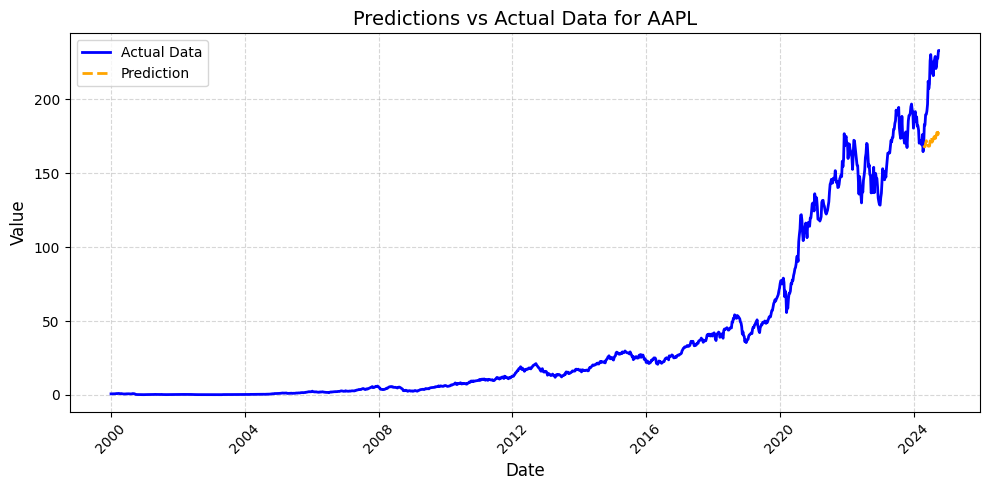

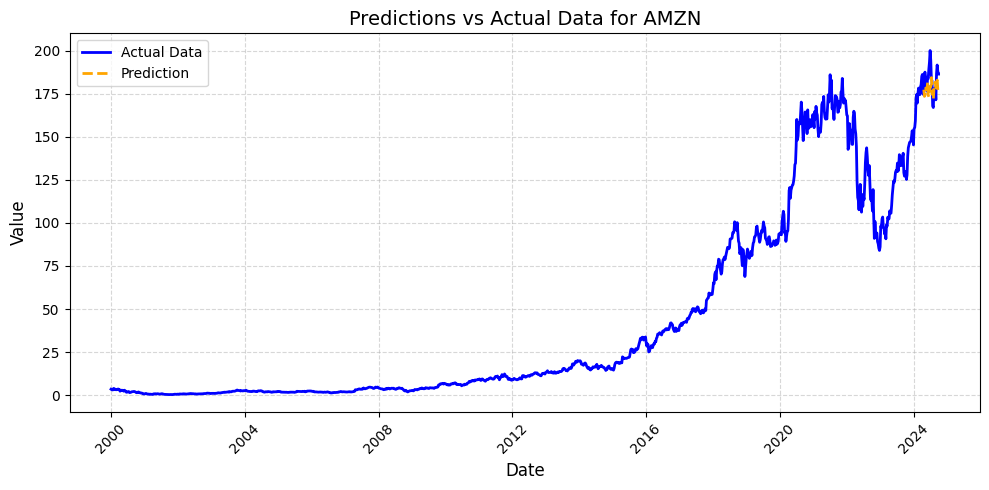

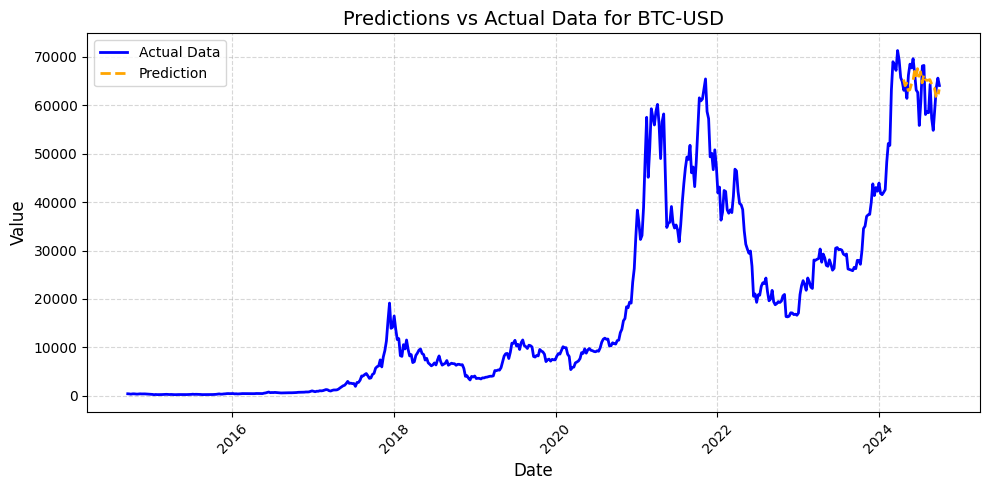

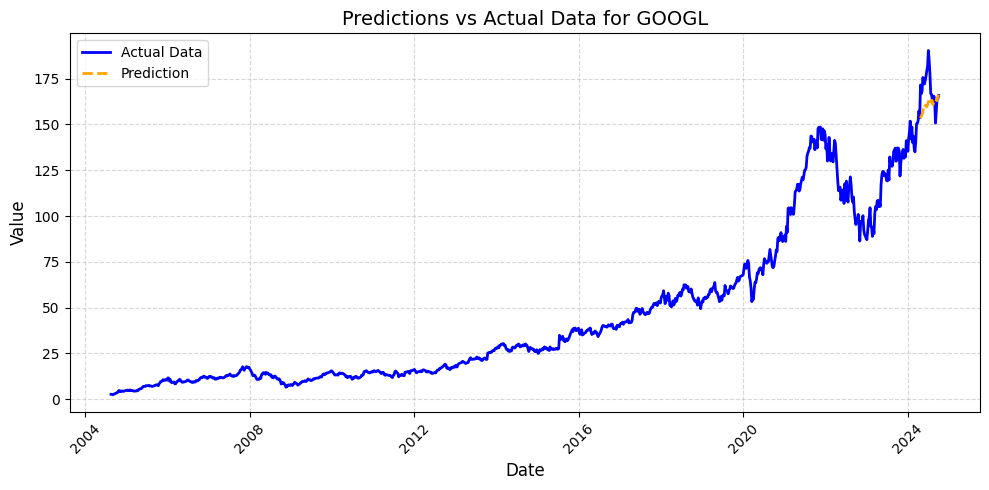

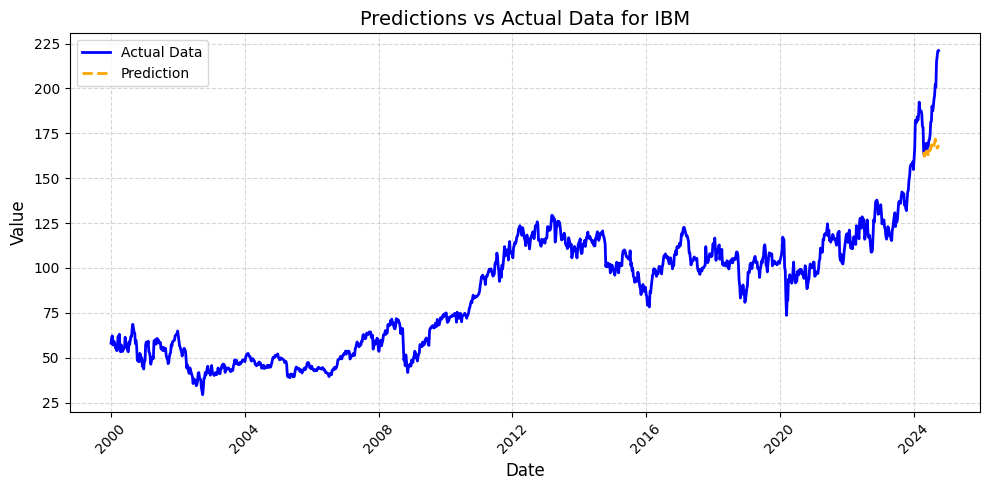

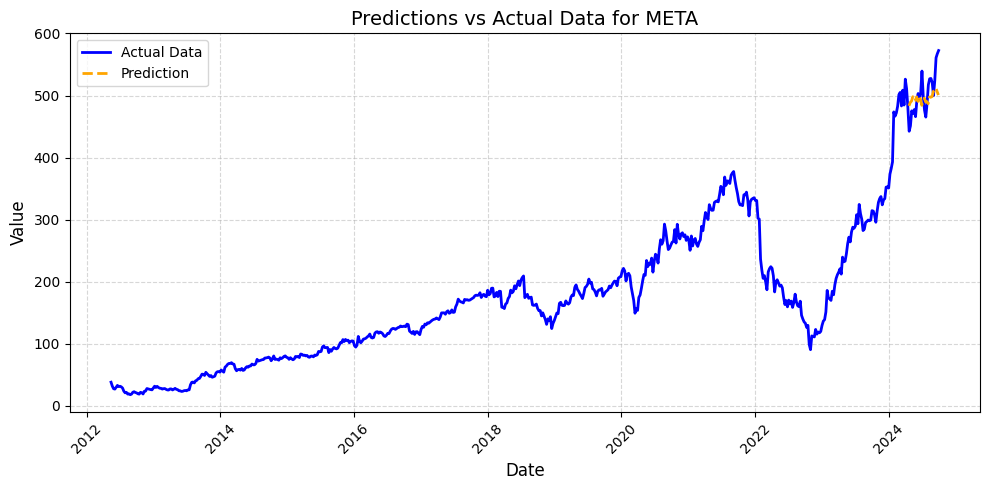

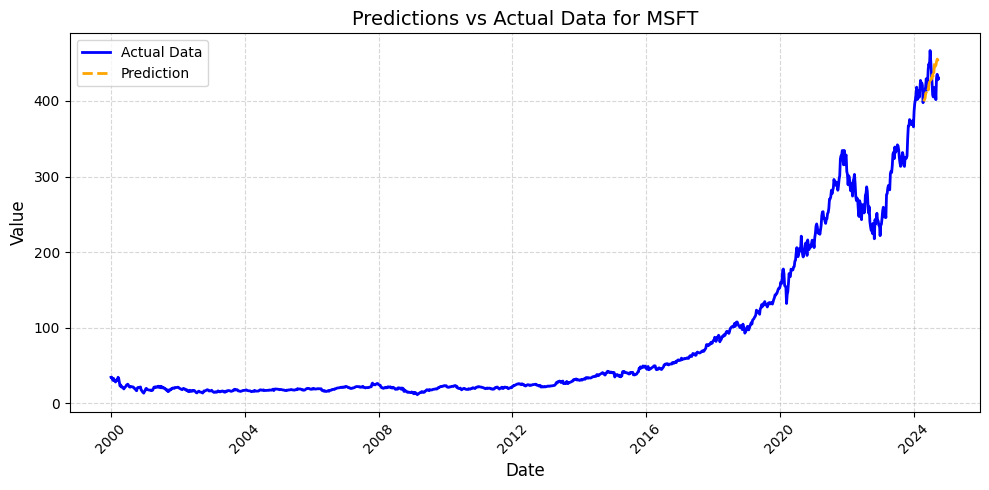

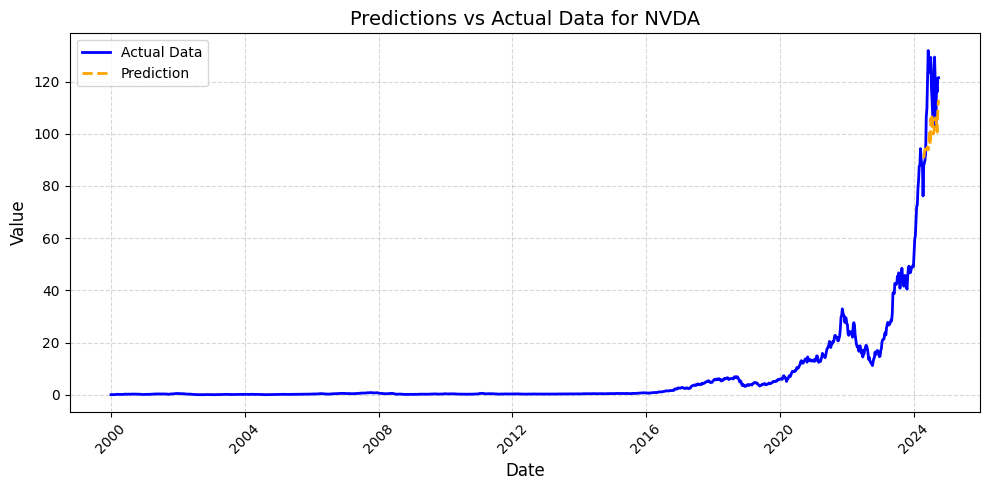

In [ ]:
# Plotting predictions for each time series
for ticker in all_forecast_df['unique_id'].unique():
    plt.figure(figsize=(10, 5))

    # Filter predictions and actual data by ticker
    forecast_data = all_forecast_df[all_forecast_df['unique_id'] == ticker]
    actual_data = Y_df[Y_df['unique_id'] == ticker]

    # Plot actual data as a solid line
    plt.plot(actual_data['ds'], actual_data['y'], label='Actual Data', linestyle='-', color='blue', linewidth=2)

    # Plot predictions as a dashed line
    plt.plot(forecast_data['ds'], forecast_data['TiDE'], label='Prediction', linestyle='--', color='orange', linewidth=2)

    # Configure the plot
    plt.title(f'Predictions vs Actual Data for {ticker}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(fontsize=10)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(visible=True, linestyle='--', alpha=0.5)

    # Show the plot
    plt.show()